In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## ***Loading Data and setting up the Dataframe***

In [ ]:
sentiment_df_politics = pd.DataFrame()
sentiment_df_sport = pd.DataFrame()
sentiment_df_entertainment = pd.DataFrame()
sentiment_df_business = pd.DataFrame()
sentiment_df_tech = pd.DataFrame()

In [ ]:
categories_list = ['politics', 'sport', 'tech', 'entertainment', 'business']

In [ ]:
sentiment_df_politics = pd.read_csv('/content/gdrive/My Drive/MIProject/LRmodel/sentiment_politics.csv')
sentiment_df_sport = pd.read_csv('/content/gdrive/My Drive/MIProject/LRmodel/sentiment_sport.csv')
sentiment_df_entertainment = pd.read_csv('/content/gdrive/My Drive/MIProject/LRmodel/sentiment_entertainment.csv')
sentiment_df_business = pd.read_csv('/content/gdrive/My Drive/MIProject/LRmodel/sentiment_business.csv')
sentiment_df_tech = pd.read_csv('/content/gdrive/My Drive/MIProject/LRmodel/sentiment_tech.csv')

In [ ]:
sentiment_df_entertainment

,Unnamed: 0,articles,summaries,category,articles_sentiment,summary_sentiment
0,1329,Comic Morris returns with sitcom\n\nComedian C...,"Comedian Chris Morris, who created controversi...",entertainment,1,1
1,1330,BBC denies Blackadder TV comeback\n\nThe BBC h...,The BBC has said there are no plans in the pip...,entertainment,0,0
2,1331,New media battle for Bafta awards\n\nThe BBC l...,ITV's Great British Spelling Test takes on the...,entertainment,1,1
3,1332,UK Directors Guild nominees named\n\nMartin Sc...,Mike Leigh's Vera Drake is among the nominees ...,entertainment,1,1
4,1333,Franz Ferdinand's art school lesson\n\nScottis...,The buzz about the band soon spread around the...,entertainment,1,1
...,...,...,...,...,...,...
381,1710,US charity anthem is re-released\n\nWe Are The...,It has been re-issued as part of a two-disc DV...,entertainment,1,1
382,1711,U2 to play at Grammy awards show\n\nIrish rock...,Irish rock band U2 are to play live at the Gra...,entertainment,1,1
383,1712,Ray DVD beats box office takings\n\nOscar-nomi...,Ray has been nominated in six Oscar categories...,entertainment,1,1
384,1713,The Producers scoops stage awards\n\nThe Produ...,- Best lighting design - His Dark Materials de...,entertainment,1,1


In [ ]:
train_df_entertainment = sentiment_df_entertainment.loc[(sentiment_df_entertainment['articles_sentiment'] == sentiment_df_entertainment['summary_sentiment'])]
train_df_entertainment = train_df_entertainment.filter(['articles','summaries'], axis=1)

In [ ]:
train_df_entertainment

,articles,summaries
0,Comic Morris returns with sitcom\n\nComedian C...,"Comedian Chris Morris, who created controversi..."
1,BBC denies Blackadder TV comeback\n\nThe BBC h...,The BBC has said there are no plans in the pip...
2,New media battle for Bafta awards\n\nThe BBC l...,ITV's Great British Spelling Test takes on the...
3,UK Directors Guild nominees named\n\nMartin Sc...,Mike Leigh's Vera Drake is among the nominees ...
4,Franz Ferdinand's art school lesson\n\nScottis...,The buzz about the band soon spread around the...
...,...,...
381,US charity anthem is re-released\n\nWe Are The...,It has been re-issued as part of a two-disc DV...
382,U2 to play at Grammy awards show\n\nIrish rock...,Irish rock band U2 are to play live at the Gra...
383,Ray DVD beats box office takings\n\nOscar-nomi...,Ray has been nominated in six Oscar categories...
384,The Producers scoops stage awards\n\nThe Produ...,- Best lighting design - His Dark Materials de...


In [ ]:
test_df_entertainment = sentiment_df_entertainment.loc[(sentiment_df_entertainment['articles_sentiment'] != sentiment_df_entertainment['summary_sentiment'])]


## ***PyTorch T5***

In [ ]:
!pip install pytorch_lightning
!pip install transformers

In [ ]:
import json
import pandas as pd 
import numpy as np 
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint 
from pytorch_lightning.loggers import TensorBoardLogger 
from sklearn.model_selection import train_test_split
from termcolor import colored 
import textwrap

from transformers import (
    AdamW,
    T5ForConditionalGeneration, 
    T5TokenizerFast as T5Tokenizer
)

from tqdm.auto import tqdm

In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize']=16, 10

In [ ]:
train_df_entertainment['articles']=train_df_entertainment['articles'].str.encode('ascii', 'ignore').str.decode('ascii')
train_df_entertainment['summaries']=train_df_entertainment['summaries'].str.encode('ascii', 'ignore').str.decode('ascii')

In [ ]:
train_df, test_df = train_test_split(train_df_entertainment, test_size = 0.1)

In [ ]:
class NewsSummaryDataset(Dataset): 
    def __init__(
        self, 
        data: pd.DataFrame,
        tokenizer: T5Tokenizer, 
        text_max_token_len: int = 512, 
        summary_max_token_len: int = 128
    ):
        self.tokenizer = tokenizer 
        self.data = data 
        self.text_max_token_len = text_max_token_len 
        self.summary_max_token_len = summary_max_token_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int): 
        data_row= self.data.iloc[index]
        
        text = data_row['articles']
        
        text_encoding= tokenizer(
            text,
            max_length=self.text_max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
        )
        
        summary_encoding = tokenizer(
            data_row['summaries'],
            padding='max_length',
            truncation=True,
            max_length=self.summary_max_token_len,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
        )

        labels = summary_encoding['input_ids']
        labels[labels == 0]=-100 # to make sure we have correct labels for T5 text generation
        
        return dict(
            text=text,
            summary=data_row['summaries'],
            text_input_ids=text_encoding['input_ids' ].flatten(),
            text_attention_mask=text_encoding['attention_mask'].flatten(),
            labels=labels.flatten(),
            labels_attention_mask=summary_encoding['attention_mask'].flatten()
        )

In [ ]:
class NewsSummaryDataModule(pl.LightningDataModule):
    def __init__(
        self, 
        train_df: pd.DataFrame, 
        test_df: pd.DataFrame, 
        tokenizer: T5Tokenizer, 
        batch_size: int = 8, 
        text_max_token_len: int = 512, 
        summary_max_token_len: int = 128
        ):
        

        super().__init__()
        
        self.train_df = train_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
        
    def setup(self, stage=None):
        self.train_dataset = NewsSummaryDataset(
          self.train_df,
          self.tokenizer,
          self.text_max_token_len,
          self.summary_max_token_len
        )
        self.test_dataset = NewsSummaryDataset(
          self.test_df,
          self.tokenizer,
          self.text_max_token_len,
          self.summary_max_token_len
        )
    def train_dataloader(self): 
        return DataLoader(
            self.train_dataset, 
            batch_size=self.batch_size, 
            shuffle=True,
            num_workers=2
        )
    def test_dataloader(self): 
        return DataLoader(
            self.test_dataset, 
            batch_size=self.batch_size, 
            shuffle=True, 
            num_workers=2
        )
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset, 
            batch_size = self.batch_size, 
            shuffle = True, 
            num_workers = 2
        )

In [ ]:
MODEL_NAME = 't5-base'

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5_fast.py:166: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [ ]:
text_token_counts, summary_token_counts = [],[]

for _, row in train_df.iterrows():
    text_token_count = len(tokenizer.encode(row['articles'])) 
    text_token_counts.append(text_token_count)
    
    summary_token_count = len(tokenizer.encode(row['summaries'])) 
    summary_token_counts.append(summary_token_count)


Token indices sequence length is longer than the specified maximum sequence length for this model (1060 > 512). Running this sequence through the model will result in indexing errors


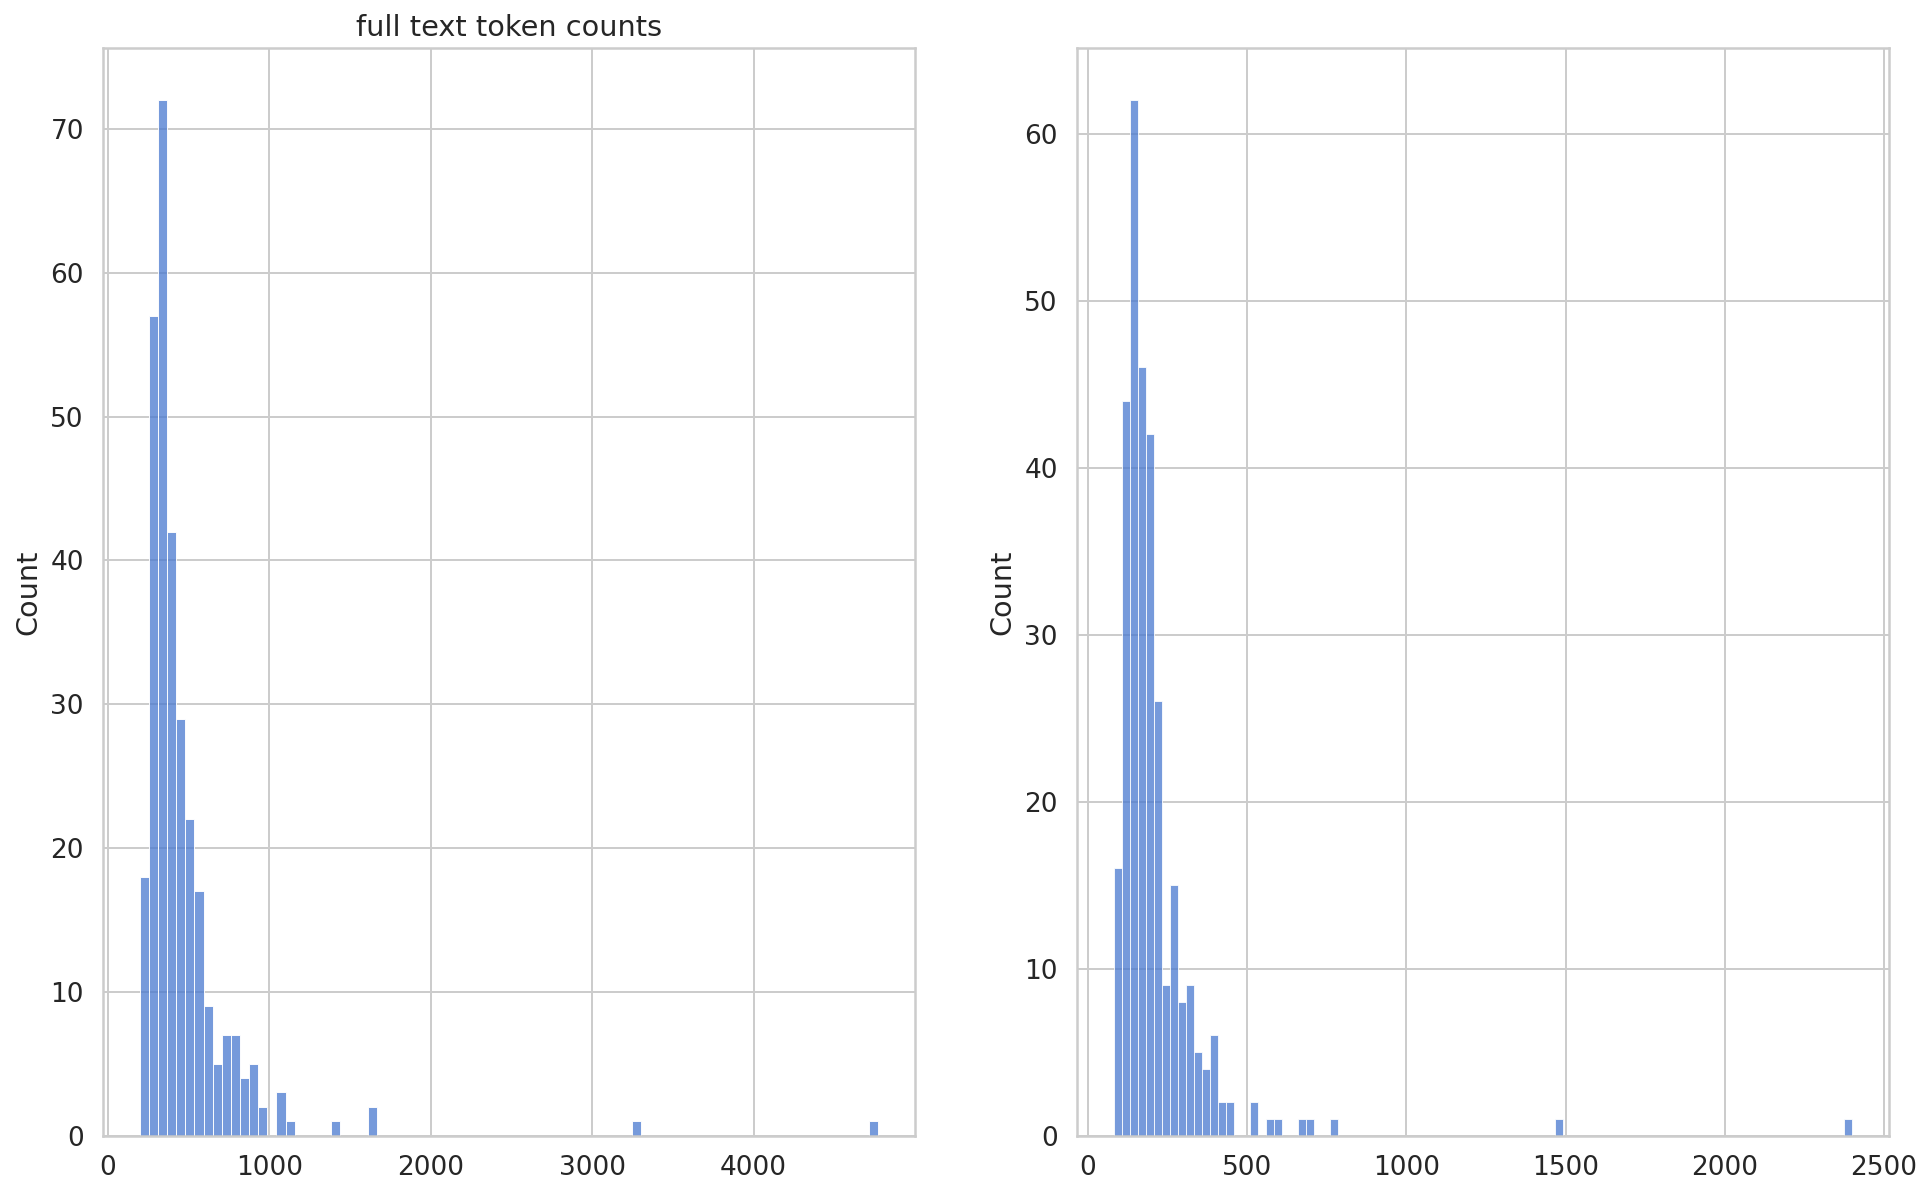

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2) 
sns.histplot(text_token_counts, ax=ax1) 
ax1.set_title('full text token counts') 
sns.histplot(summary_token_counts, ax=ax2)

In [ ]:
N_EPOCHS = 3
BATCH_SIZE = 8

data_module = NewsSummaryDataModule(train_df, test_df, tokenizer)

**Model**

In [ ]:
class NewsSummaryModel(pl.LightningModule):
    def __init__(self):

      super().__init__()

      self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)

    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
      output = self.model(
      input_ids,
      attention_mask=attention_mask,
      labels=labels,
      decoder_attention_mask=decoder_attention_mask
      )
      return output.loss, output.logits

    def training_step(self, batch, batch_size): 
      input_ids = batch['text_input_ids']
      attention_mask = batch['text_attention_mask']
      labels = batch['labels']
      labels_attention_mask = batch['labels_attention_mask']

      loss, output = self(
          input_ids = input_ids, 
          attention_mask = attention_mask, 
          decoder_attention_mask = labels_attention_mask, 
          labels = labels
      )

      self.log("test_loss", loss, prog_bar = True, logger = True)
      return loss

    def validation_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids = input_ids,
            attention_mask = attention_mask,
            decoder_attention_mask = labels_attention_mask,
            labels = labels
        )

        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_size): 
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask'] 
        labels = batch['labels'] 
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids = input_ids,
            attention_mask = attention_mask,
            decoder_attention_mask=labels_attention_mask, 
            labels = labels
        )
        self.log('test loss', loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)



In [ ]:
model = NewsSummaryModel()

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath = '/content/gdrive/My Drive/MIProject/T5model', 
    filename = 'best-checkpoint', 
    save_top_k = 1, 
    verbose = True, 
    monitor = 'val_loss', 
    mode = 'min'
)

logger = TensorBoardLogger("lightning_logs", name='news-summary')

trainer = pl.Trainer(
    logger = logger,
    callbacks=[checkpoint_callback],
    max_epochs = N_EPOCHS, 
    gpus=1
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
torch.cuda.empty_cache()

In [ ]:
import gc
gc.collect()

69

In [ ]:
trainer.fit(model, data_module)

In [ ]:
trained_model = NewsSummaryModel.load_from_checkpoint(
    '/content/gdrive/My Drive/MIProject/T5model/best-checkpoint.ckpt'
)
trained_model.freeze()

In [ ]:
def summarizeText(text):
  text_encoding = tokenizer(
      text,
      max_length = 512,
      padding = 'max_length',
      truncation = True,
      return_attention_mask = True,
      add_special_tokens = True,
      return_tensors = 'pt'
  )

  generated_ids = trained_model.model.generate(
      input_ids = text_encoding['input_ids'],
      attention_mask = text_encoding['attention_mask'],
      max_length = 150,
      num_beams = 2,
      repetition_penalty = 2.5,
      length_penalty = 1.0,
      early_stopping = True
  )

  preds = [
      tokenizer.decode(gen_id, skip_special_tokens = True, clean_up_tokenization_spaces=True)
      for gen_id in generated_ids
  ]

  return "".join(preds)

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
def question_answer(context):
    return summarizeText(context)

gr.Interface(fn=question_answer, inputs="text", outputs="text").launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [ ]:
test_df.iloc[0]['articles']

'Franz Ferdinand\'s art school lesson\n\nScottish rock band Franz Ferdinand, who shot to prominence in 2004, have won two Brit Awards.\n\nWith their self-titled debut, Franz Ferdinand have achieved what most rock bands crave - high credibility and critical acclaim while also selling stacks of CDs. They have risen to the head of the UK\'s art rock ranks with an album of songs that are catchy, creative and original enough to sound fresh. With a cool, spiky, fun sound previously associated with bands like Talking Heads, they hit upon a style that had been out of fashion for a while and so was ripe for another airing. Their first UK single hit number three last January, followed by two more top 20 hits, while the album has sold more than 600,000 copies in 11 months on release. In September it was named album of the year winning the prestigious Mercury Music Prize.\n\nOn the festivals circuit, they have been one of the main attractions for huge crowds at Glastonbury, T in the Park and Readi

In [ ]:
test_df.iloc[0]['summaries']

'The buzz about the band soon spread around the music industry and 40 record labels turned up to one gig in Glasgow - which the band thought was "totally ridiculous".Scottish rock band Franz Ferdinand, who shot to prominence in 2004, have won two Brit Awards.At the turn of the year, Kapranos told BBC News Online the band were fed up with serious bands in "that post-rock thing that seemed to be doing its damndest to avoid any bloody tune".Nevertheless Franz Ferdinand were the only UK band to win an MTV Video Music Award this year, taking the breakthrough video crown for Take Me Out.Franz Ferdinand had a question they asked themselves every time they wrote a song, Kapranos said.In September it was named album of the year winning the prestigious Mercury Music Prize.With a cool, spiky, fun sound previously associated with bands like Talking Heads, they hit upon a style that had been out of fashion for a while and so was ripe for another airing.The four-piece met two years ago when drummer 

## ***Using Trained PyTorch on our dataset***

In [ ]:
test_df_entertainment['pred_summary_pt'] = ""

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test_df_entertainment['pred_summary_pt'] = test_df_entertainment.apply(lambda x: summarizeText(x['articles']), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test_df_entertainment

,Unnamed: 0,articles,summaries,category,articles_sentiment,summary_sentiment,pred_summary_t5,pred_summary_pt
7,1336,iTunes now selling Band Aid song\n\nIpod owner...,Ipod owners can now download the Band Aid sing...,entertainment,1,0,,Ipod owners can now download the Band Aid sing...
10,1339,Briton wins short film Oscar\n\nThree of the f...,"""The other nominees said they made their films...",entertainment,0,1,,Arnold's gritty drama Wasp is about a single m...
15,1344,Britney attacks 'false tabloids'\n\nPop star B...,"Pop star Britney Spears has attacked ""false"" a...",entertainment,0,1,,"Pop star Britney Spears has attacked ""false"" a..."
16,1345,Prince crowned 'top music earner'\n\nPrince ea...,Although she grossed more than Prince last yea...,entertainment,1,0,,The singer banked $56.5m (£30.4m) from concert...
24,1353,No UK premiere for Rings musical\n\nThe produc...,The producers behind the Lord of the Rings mus...,entertainment,1,0,,The producers behind the Lord of the Rings mus...
34,1363,Prince crowned 'top music earner'\n\nPrince ea...,Although she grossed more than Prince last yea...,entertainment,1,0,,The singer banked $56.5m (£30.4m) from concert...
46,1375,Robots march to US cinema summit\n\nAnimated m...,Animated movie Robots has opened at the top of...,entertainment,1,0,,"Meanwhile, Will Smith comedy Hitch has become ..."
48,1377,Label withdraws McFadden's video\n\nThe new vi...,The head of Christian Brothers' school St Fint...,entertainment,1,0,,The head of Christian Brothers' school St Fint...
64,1393,Byrds producer Melcher dies at 62\n\nRecord pr...,"Record producer Terry Melcher, who was behind ...",entertainment,1,0,,"Record producer Terry Melcher, who was behind ..."
65,1394,Row threatens Hendrix museum plan\n\nProposals...,"Janie Hendrix, the guitarist's stepsister, sai...",entertainment,0,1,,Now Mr Goldman is calling for the authority to...


In [ ]:
test_df_entertainment.to_csv('/content/gdrive/My Drive/MIProject/T5model/test_entertainment.csv')

## ***Load LR Model For Sentiment***

In [ ]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import pickle
import re

In [ ]:
def load_models():
    
    # Load the vectoriser.
    file = open('/content/gdrive/My Drive/MIProject/Models/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('/content/gdrive/My Drive/MIProject/Models/Sentiment-LR.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

In [ ]:
vectorizer, LRmodel = load_models()

In [ ]:
def _preprocess_for_sentiment(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.    
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [ ]:
def _predict(vectoriser, model, data):
    # Predict the sentiment
    text = []
    text.append(data)
    textdata = vectoriser.transform(_preprocess_for_sentiment(text))
    sentiment = model.predict(textdata)
    return sentiment[0]

## ***PyTorch Results + LR Model for getting Sentiment of Summarized Articles***

In [ ]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
test_df_entertainment['pred_summary_sentiment'] = test_df_entertainment.apply(lambda x: _predict(vectorizer, LRmodel, x['pred_summary_pt']), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test_df_entertainment.to_csv('/content/gdrive/My Drive/MIProject/T5model/test_entertainment_sentiment.csv')

In [ ]:
results = test_df_entertainment.loc[(test_df_entertainment['articles_sentiment'] == test_df_entertainment['pred_summary_sentiment'])]

In [ ]:
columns_titles = ['articles', 'articles_sentiment', 'summaries', 'summary_sentiment', 'pred_summary_pt', 'pred_summary_sentiment']
results = results.reindex(columns=columns_titles)

In [ ]:
results

,articles,articles_sentiment,summaries,summary_sentiment,pred_summary_pt,pred_summary_sentiment
7,iTunes now selling Band Aid song\n\nIpod owner...,1,Ipod owners can now download the Band Aid sing...,0,Ipod owners can now download the Band Aid sing...,1
10,Briton wins short film Oscar\n\nThree of the f...,0,"""The other nominees said they made their films...",1,Arnold's gritty drama Wasp is about a single m...,0
16,Prince crowned 'top music earner'\n\nPrince ea...,1,Although she grossed more than Prince last yea...,0,The singer banked $56.5m (£30.4m) from concert...,1
24,No UK premiere for Rings musical\n\nThe produc...,1,The producers behind the Lord of the Rings mus...,0,The producers behind the Lord of the Rings mus...,1
34,Prince crowned 'top music earner'\n\nPrince ea...,1,Although she grossed more than Prince last yea...,0,The singer banked $56.5m (£30.4m) from concert...,1
65,Row threatens Hendrix museum plan\n\nProposals...,0,"Janie Hendrix, the guitarist's stepsister, sai...",1,Now Mr Goldman is calling for the authority to...,0
67,UK debut for Kevin Spacey movie\n\nHollywood s...,0,"""Bobby Darin was one of the greatest entertain...",1,"""I knew absolutely nothing about Bobby Darin b...",0
80,Snow Patrol bassist exits group\n\nSnow Patrol...,0,"Snow Patrol had ""no other course of action"" bu...",1,Mark McClelland had been in the band for more ...,0
117,Fox 'too reliant on reality TV'\n\nThe head of...,0,Five other episodes of the show had also been ...,1,The head of US TV network Fox has admitted the...,0
124,Ring of Fire hit co-writer dies\n\nMerle Kilgo...,0,He then wrote Ring of Fire with June Carter Ca...,1,"Merle Kilgore, co-writer of the country hit Ri...",0


In [ ]:
print(test_df_entertainment.shape)
print(results.shape)

(47, 9)
(24, 6)


## ***Extractive***

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
from nltk.stem import WordNetLemmatizer

In [ ]:
def preprocess_for_sentiment(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.    
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [ ]:
#importing libraries
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
import bs4 as BeautifulSoup
import urllib.request


def predict_(vectoriser, model, data):
    # Predict the sentiment
    text = []
    text.append(data)
    textdata = vectoriser.transform(preprocess_for_sentiment(text))
    sentiment = model.predict(textdata)
    return sentiment[0]

def _create_dictionary_table(text_string) -> dict:
   
    #removing stop words
    stop_words = set(stopwords.words("english"))
    
    words = word_tokenize(text_string)
    
    #reducing words to their root form
    stem = PorterStemmer()
    
    #creating dictionary for the word frequency table
    frequency_table = dict()
    for wd in words:
        wd = stem.stem(wd)
        if wd in stop_words:
            continue
        if wd in frequency_table:
            frequency_table[wd] += 1
        else:
            frequency_table[wd] = 1

    return frequency_table


def _calculate_sentence_scores(sentences, frequency_table) -> dict:

    x_max = max(frequency_table.values())
    x_min = min(frequency_table.values())

    factor = 1.0/(x_max-x_min)
    for k in frequency_table:
      frequency_table[k] = (frequency_table[k] - x_min)*factor
    #algorithm for scoring a sentence by its words

    sentence_weight = dict()
    count = [0, 0]

    for sentence in sentences:
        sentiment_score = predict_(vectorizer, LRmodel, sentence)
        if sentiment_score == 0:
          count[1] += 1
        else:
          count[0] += 1
        sentence_weight[sentence[:7]] = sentiment_score
  
    if count[0] < count[1]:  #there are more negative sentences
      for sentence in sentences:
        sentence_weight[sentence[:7]] = 1-sentiment_score
    for sentence in sentences:
        sentence_wordcount = (len(word_tokenize(sentence)))
        sentence_wordcount_without_stop_words = 0
        for word_weight in frequency_table:
            if word_weight in sentence.lower():
                sentence_wordcount_without_stop_words += 1
                if sentence[:7] in sentence_weight:
                    sentence_weight[sentence[:7]] += frequency_table[word_weight]
                else:
                    sentence_weight[sentence[:7]] += frequency_table[word_weight]
                    # sentence_weight[sentence[:7]] = sentiment_score

        sentence_weight[sentence[:7]] = sentence_weight[sentence[:7]] / sentence_wordcount_without_stop_words
    return sentence_weight

def _calculate_average_score(sentence_weight) -> int:
   
    #calculating the average score for the sentences
    sum_values = 0
    for entry in sentence_weight:
        sum_values += sentence_weight[entry]

    #getting sentence average value from source text
    average_score = (sum_values / len(sentence_weight))

    return average_score

def _get_article_summary(sentences, sentence_weight, threshold):
    sentence_counter = 0
    article_summary = ''

    for sentence in sentences:
        if sentence[:7] in sentence_weight and sentence_weight[sentence[:7]] >= (threshold):
            article_summary += " " + sentence
            sentence_counter += 1

    return article_summary

def _run_article_summary(article):
    
    #creating a dictionary for the word frequency table
    frequency_table = _create_dictionary_table(article)

    #tokenizing the sentences
    sentences = sent_tokenize(article)

    #algorithm for scoring a sentence by its words
    sentence_scores = _calculate_sentence_scores(sentences, frequency_table)

    #getting the threshold
    threshold = _calculate_average_score(sentence_scores)

    #producing the summary
    article_summary = _get_article_summary(sentences, sentence_scores, threshold)

    return article_summary


In [ ]:
def preprocess(article):
  refined_article = ''
  for i in article.split():
    refined_article += i.strip() + " "
  return refined_article

In [ ]:
sentiment_df_entertainment['pred_summary'] = ""
sentiment_df_entertainment.drop(['category'], axis=1)

,Unnamed: 0,articles,summaries,articles_sentiment,summary_sentiment,pred_summary
0,1329,Comic Morris returns with sitcom\n\nComedian C...,"Comedian Chris Morris, who created controversi...",1,1,
1,1330,BBC denies Blackadder TV comeback\n\nThe BBC h...,The BBC has said there are no plans in the pip...,0,0,
2,1331,New media battle for Bafta awards\n\nThe BBC l...,ITV's Great British Spelling Test takes on the...,1,1,
3,1332,UK Directors Guild nominees named\n\nMartin Sc...,Mike Leigh's Vera Drake is among the nominees ...,1,1,
4,1333,Franz Ferdinand's art school lesson\n\nScottis...,The buzz about the band soon spread around the...,1,1,
...,...,...,...,...,...,...
381,1710,US charity anthem is re-released\n\nWe Are The...,It has been re-issued as part of a two-disc DV...,1,1,
382,1711,U2 to play at Grammy awards show\n\nIrish rock...,Irish rock band U2 are to play live at the Gra...,1,1,
383,1712,Ray DVD beats box office takings\n\nOscar-nomi...,Ray has been nominated in six Oscar categories...,1,1,
384,1713,The Producers scoops stage awards\n\nThe Produ...,- Best lighting design - His Dark Materials de...,1,1,


In [ ]:
sentiment_df_entertainment['pred_summary'] = sentiment_df_entertainment.apply(lambda x: _run_article_summary(preprocess(x['articles'])), axis=1)
sentiment_df_entertainment['pred_summary_sentiment'] = sentiment_df_entertainment.apply(lambda x: predict_(vectorizer, LRmodel, x['pred_summary']), axis=1)

In [ ]:
columns_titles = ['articles', 'articles_sentiment', 'summaries', 'summary_sentiment', 'pred_summary', 'pred_summary_sentiment']
sentiment_df_entertainment = sentiment_df_entertainment.reindex(columns=columns_titles)

In [ ]:
sentiment_df_entertainment

,articles,articles_sentiment,summaries,summary_sentiment,pred_summary,pred_summary_sentiment
0,Comic Morris returns with sitcom\n\nComedian C...,1,"Comedian Chris Morris, who created controversi...",1,Comic Morris returns with sitcom Comedian Chr...,1
1,BBC denies Blackadder TV comeback\n\nThe BBC h...,0,The BBC has said there are no plans in the pip...,0,"Robinson added he would ""love"" to do another ...",1
2,New media battle for Bafta awards\n\nThe BBC l...,1,ITV's Great British Spelling Test takes on the...,1,New media battle for Bafta awards The BBC lea...,1
3,UK Directors Guild nominees named\n\nMartin Sc...,1,Mike Leigh's Vera Drake is among the nominees ...,1,UK Directors Guild nominees named Martin Scor...,1
4,Franz Ferdinand's art school lesson\n\nScottis...,1,The buzz about the band soon spread around the...,1,Franz Ferdinand's art school lesson Scottish ...,1
...,...,...,...,...,...,...
381,US charity anthem is re-released\n\nWe Are The...,1,It has been re-issued as part of a two-disc DV...,1,"It topped the charts in the US and UK, raisin...",1
382,U2 to play at Grammy awards show\n\nIrish rock...,1,Irish rock band U2 are to play live at the Gra...,1,U2 to play at Grammy awards show Irish rock b...,1
383,Ray DVD beats box office takings\n\nOscar-nomi...,1,Ray has been nominated in six Oscar categories...,1,Ray has been nominated in six Oscar categorie...,1
384,The Producers scoops stage awards\n\nThe Produ...,1,- Best lighting design - His Dark Materials de...,1,Mel Brooks' hit show triumphed in the battle ...,1


In [ ]:
results = sentiment_df_entertainment.loc[(sentiment_df_entertainment['articles_sentiment'] == sentiment_df_entertainment['pred_summary_sentiment'])]

In [ ]:
print(sentiment_df_entertainment.shape)
print(results.shape)

(386, 6)
(333, 6)


## ***KERAS***

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}


In [ ]:
train_df_entertainment['articles'][:10]

0     Comic Morris returns with sitcom\n\nComedian Chris Morris, who created controversial TV show Brass Eye, is to return to screens with a new sitcom about a spoof London media worker.\n\nMorris will ...
1     BBC denies Blackadder TV comeback\n\nThe BBC has said there are no plans in the pipeline for a new series of hit comedy Blackadder, which ended in 1989.\n\nTony Robinson, who played the servant Ba...
2     New media battle for Bafta awards\n\nThe BBC leads the nominations for the Bafta Interactive Awards, including one for the Radio Times website and one for Sport Interactive's Euro 2004 coverage.\n...
3     UK Directors Guild nominees named\n\nMartin Scorsese and Clint Eastwood are among the nominees for the top prize at the Directors Guild of Great Britain awards, now in their second year.\n\nThe Os...
4     Franz Ferdinand's art school lesson\n\nScottish rock band Franz Ferdinand, who shot to prominence in 2004, have won two Brit Awards.\n\nWith their self-titled debut, Fran

In [ ]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in train_df_entertainment['articles']:
    cleaned_text.append(text_cleaner(t))

In [ ]:
train_df_entertainment['summaries'][:10]

0     Comedian Chris Morris, who created controversial TV show Brass Eye, is to return to screens with a new sitcom about a spoof London media worker.As well as Brass Eye, Morris was behind another news...
1     The BBC has said there are no plans in the pipeline for a new series of hit comedy Blackadder, which ended in 1989.The poignant finale was later voted the best farewell episode of a TV series.Robi...
2     ITV's Great British Spelling Test takes on the BBC's Olympics and Spooks Interactive for the interactive TV award.And the Guardian takes three of a possible five nominations in the news and sport ...
3     Mike Leigh's Vera Drake is among the nominees for best British film.In the TV categories, comedy series Early Doors and The Alan Clark Diaries will compete for the best directing award for a 30-mi...
4     The buzz about the band soon spread around the music industry and 40 record labels turned up to one gig in Glasgow - which the band thought was "totally ridiculous".Scott

In [ ]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in train_df_entertainment['summaries']:
    cleaned_summary.append(summary_cleaner(t))

train_df_entertainment['cleaned_text']=cleaned_text
train_df_entertainment['cleaned_summary']=cleaned_summary
train_df_entertainment['cleaned_summary'].replace('', np.nan, inplace=True)
train_df_entertainment.dropna(axis=0,inplace=True)

In [ ]:
train_df_entertainment['cleaned_summary'] = train_df_entertainment['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [ ]:
for i in range(5):
    print("Review:",train_df_entertainment['cleaned_text'][i])
    print("Summary:",train_df_entertainment['cleaned_summary'][i])
    print("\n")

Review: comic morris returns sitcom comedian chris morris created controversial show brass eye return screens new sitcom spoof london media worker morris direct write nathan barley character cult website home channel send stereotypical cool metropolitan media scene nicholas burns title role brass eye satire media handling paedophilia sparked complaints nathan barley character driven comedy according charlie brooker created home written series barley described webmaster guerrilla film maker screenwriter words self facilitating media node story also feature dan ashcroft style magazine columnist sister claire film maker hates cool scene well brass eye morris behind another news show satire day today dark sketch comedy jam new show expected begin february
Summary: _START_ comedian chris morris who created controversial tv show brass eye is to return to screens with new sitcom about spoof london media worker as well as brass eye morris was behind another news show satire the day today and d

In [ ]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in train_df_entertainment['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in train_df_entertainment['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df

,text,summary
0,107,74
1,91,75
2,156,133
3,168,126
4,313,279
...,...,...
334,78,62
335,112,94
336,132,91
337,413,416


In [ ]:
max_len_text=80
max_len_summary=10

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(train_df_entertainment['cleaned_text'],train_df_entertainment['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True) 

In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [ ]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [ ]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 80, 500)      4820500     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 80, 500),    2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:], epochs=250, batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


In [ ]:
!pip install torchtext==0.10.0
!pip install --quiet transformers==4.5.0
!pip install --quiet pytorch-lightning==1.2.7
import pytorch_lightning as pl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
import json
import pandas as pd
import numpy as np 
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint 
from pytorch_lightning.loggers import TensorBoardLogger 
from sklearn.model_selection import train_test_split 
from termcolor import colored
import textwrap
from transformers import (
  AdamW,
  T5ForConditionalGeneration, 
  T5TokenizerFast as T5Tokenizer
)
from tqdm.auto import tqdm

/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


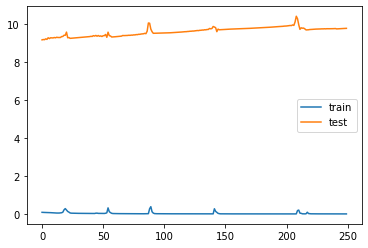

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index
len(reverse_target_word_index)

6186

In [ ]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(5):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

Review: actress award said red carpet exciting part job always surreal nice nice said martin scorsese whose movie aviator went win best film said honoured meant lot said great british cinema since give new energy see best coming england every two three years whole new tough young film makers even older ones making good films recognise way great honour british actor clive owen golden globe bafta supporting role closer said meant lot ceremony said really baftas bottom line celebration british films 
Original summary: watson who plays hermione in the harry potter films 
1/1 [==============================] - 0s 16ms/step
Predicted summary:  left west with his jaw wired shut in


Review: come dancing win top entertainment moment little britain breast sketch comedy prize moments shown bbc one gmt wednesday double gold medal winner holmes topped best sports moment category beating maria wimbledon triumph matthew victory went take overall prize golden moment sight former royal correspondent b

## ***Similarity***

In [ ]:
!pip install --upgrade spacy

In [ ]:
import spacy.cli
spacy.cli.download("en_core_web_lg")
nlp = spacy.load("en_core_web_lg")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
from numpy import unicode

<ipython-input-36-03ba566f0dcf>:1: DeprecationWarning: `np.unicode` is a deprecated alias for `np.compat.unicode`. To silence this warning, use `np.compat.unicode` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `str` for which `np.compat.unicode` is itself an alias. Doing this will not modify any behaviour and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from numpy import unicode


In [ ]:
def find_sim(doc1, doc2):
  doc1 = nlp(unicode(doc1))
  doc2 = nlp(unicode(doc2))
  return doc1.similarity(doc2)

In [ ]:
sentiment_df_entertainment['similarity'] = 0

In [ ]:
sentiment_df_entertainment['similarity'] = sentiment_df_entertainment.apply(lambda x: find_sim(x['summaries'], x['pred_summary']), axis=1)

In [ ]:
sentiment_df_entertainment

,articles,articles_sentiment,summaries,summary_sentiment,pred_summary,pred_summary_sentiment,similarity
0,Comic Morris returns with sitcom\n\nComedian C...,1,"Comedian Chris Morris, who created controversi...",1,Comic Morris returns with sitcom Comedian Chr...,1,0.954005
1,BBC denies Blackadder TV comeback\n\nThe BBC h...,0,The BBC has said there are no plans in the pip...,0,"Robinson added he would ""love"" to do another ...",1,0.988295
2,New media battle for Bafta awards\n\nThe BBC l...,1,ITV's Great British Spelling Test takes on the...,1,New media battle for Bafta awards The BBC lea...,1,0.987563
3,UK Directors Guild nominees named\n\nMartin Sc...,1,Mike Leigh's Vera Drake is among the nominees ...,1,UK Directors Guild nominees named Martin Scor...,1,0.953411
4,Franz Ferdinand's art school lesson\n\nScottis...,1,The buzz about the band soon spread around the...,1,Franz Ferdinand's art school lesson Scottish ...,1,0.987818
...,...,...,...,...,...,...,...
381,US charity anthem is re-released\n\nWe Are The...,1,It has been re-issued as part of a two-disc DV...,1,"It topped the charts in the US and UK, raisin...",1,0.975509
382,U2 to play at Grammy awards show\n\nIrish rock...,1,Irish rock band U2 are to play live at the Gra...,1,U2 to play at Grammy awards show Irish rock b...,1,0.981098
383,Ray DVD beats box office takings\n\nOscar-nomi...,1,Ray has been nominated in six Oscar categories...,1,Ray has been nominated in six Oscar categorie...,1,0.909008
384,The Producers scoops stage awards\n\nThe Produ...,1,- Best lighting design - His Dark Materials de...,1,Mel Brooks' hit show triumphed in the battle ...,1,0.875140


In [ ]:
sentiment_df_entertainment.to_csv('/content/gdrive/My Drive/MIProject/simple_extractive_similarity.csv')

## ***Simple Extractive without Sentiment***

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
import bs4 as BeautifulSoup
import urllib.request

def predict_(vectoriser, model, data):
    # Predict the sentiment
    text = []
    text.append(data)
    textdata = vectoriser.transform(preprocess_for_sentiment(text))
    sentiment = model.predict(textdata)
    return sentiment[0]

def _create_dictionary_table(text_string) -> dict:
   
    #removing stop words
    stop_words = set(stopwords.words("english"))
    
    words = word_tokenize(text_string)
    
    #reducing words to their root form
    stem = PorterStemmer()
    
    #creating dictionary for the word frequency table
    frequency_table = dict()
    for wd in words:
        wd = stem.stem(wd)
        if wd in stop_words:
            continue
        if wd in frequency_table:
            frequency_table[wd] += 1
        else:
            frequency_table[wd] = 1

    return frequency_table
def _calculate_sentence_scores(sentences, frequency_table) -> dict:   

    #algorithm for scoring a sentence by its words
    sentence_weight = dict()

    for sentence in sentences:
        sentence_wordcount = (len(word_tokenize(sentence)))
        sentence_wordcount_without_stop_words = 0
        for word_weight in frequency_table:
            if word_weight in sentence.lower():
                sentence_wordcount_without_stop_words += 1
                if sentence[:7] in sentence_weight:
                    sentence_weight[sentence[:7]] += frequency_table[word_weight]
                else:
                    sentence_weight[sentence[:7]] = frequency_table[word_weight]

        sentence_weight[sentence[:7]] = sentence_weight[sentence[:7]] / sentence_wordcount_without_stop_words

       

    return sentence_weight

def _calculate_average_score(sentence_weight) -> int:
   
    #calculating the average score for the sentences
    sum_values = 0
    for entry in sentence_weight:
        sum_values += sentence_weight[entry]

    #getting sentence average value from source text
    average_score = (sum_values / len(sentence_weight))

    return average_score

def _get_article_summary(sentences, sentence_weight, threshold):
    sentence_counter = 0
    article_summary = ''

    for sentence in sentences:
        if sentence[:7] in sentence_weight and sentence_weight[sentence[:7]] >= (threshold):
            article_summary += " " + sentence
            sentence_counter += 1

    return article_summary

def _run_article_summary(article):
    
    #creating a dictionary for the word frequency table
    frequency_table = _create_dictionary_table(article)

    #tokenizing the sentences
    sentences = sent_tokenize(article)

    #algorithm for scoring a sentence by its words
    sentence_scores = _calculate_sentence_scores(sentences, frequency_table)

    #getting the threshold
    threshold = _calculate_average_score(sentence_scores)

    #producing the summary
    article_summary = _get_article_summary(sentences, sentence_scores, threshold)

    return article_summary

In [ ]:
def preprocess(article):
  refined_article = ''
  for i in article.split():
    refined_article += i.strip() + " "
  return refined_article

In [ ]:
sentiment_df_entertainment['pred_summary_nosent'] = ""
sentiment_df_entertainment['pred_summary_sentiment_nosent'] = 0

In [ ]:
sentiment_df_entertainment['pred_summary_nosent'] = sentiment_df_entertainment.apply(lambda x: _run_article_summary(preprocess(x['articles'])), axis=1)
sentiment_df_entertainment['pred_summary_sentiment_nosent'] = sentiment_df_entertainment.apply(lambda x: predict_(vectorizer, LRmodel, x['pred_summary_nosent']), axis=1)

In [ ]:
results = sentiment_df_entertainment.loc[(sentiment_df_entertainment['articles_sentiment'] == sentiment_df_entertainment['pred_summary_sentiment_nosent'])]

In [ ]:
sentiment_df_entertainment

,articles,articles_sentiment,summaries,summary_sentiment,pred_summary,pred_summary_sentiment,pred_summary_nosent,pred_summary_sentiment_nosent
0,Comic Morris returns with sitcom\n\nComedian C...,1,"Comedian Chris Morris, who created controversi...",1,Comic Morris returns with sitcom Comedian Chr...,1,Comic Morris returns with sitcom Comedian Chr...,1
1,BBC denies Blackadder TV comeback\n\nThe BBC h...,0,The BBC has said there are no plans in the pip...,0,"Robinson added he would ""love"" to do another ...",1,BBC denies Blackadder TV comeback The BBC has...,0
2,New media battle for Bafta awards\n\nThe BBC l...,1,ITV's Great British Spelling Test takes on the...,1,New media battle for Bafta awards The BBC lea...,1,New media battle for Bafta awards The BBC lea...,1
3,UK Directors Guild nominees named\n\nMartin Sc...,1,Mike Leigh's Vera Drake is among the nominees ...,1,UK Directors Guild nominees named Martin Scor...,1,UK Directors Guild nominees named Martin Scor...,1
4,Franz Ferdinand's art school lesson\n\nScottis...,1,The buzz about the band soon spread around the...,1,Franz Ferdinand's art school lesson Scottish ...,1,Franz Ferdinand's art school lesson Scottish ...,1
...,...,...,...,...,...,...,...,...
381,US charity anthem is re-released\n\nWe Are The...,1,It has been re-issued as part of a two-disc DV...,1,"It topped the charts in the US and UK, raisin...",1,"It topped the charts in the US and UK, raisin...",1
382,U2 to play at Grammy awards show\n\nIrish rock...,1,Irish rock band U2 are to play live at the Gra...,1,U2 to play at Grammy awards show Irish rock b...,1,U2 to play at Grammy awards show Irish rock b...,1
383,Ray DVD beats box office takings\n\nOscar-nomi...,1,Ray has been nominated in six Oscar categories...,1,Ray has been nominated in six Oscar categorie...,1,Ray has been nominated in six Oscar categorie...,1
384,The Producers scoops stage awards\n\nThe Produ...,1,- Best lighting design - His Dark Materials de...,1,Mel Brooks' hit show triumphed in the battle ...,1,The Producers scoops stage awards The Produce...,1


In [ ]:
print(results.shape)

(342, 8)
